# AFM Particle Segmentation & Feature Extraction
**Sample:** GV0130001  
**Instrument:** Asylum Research AFM | `.ibw` format (256×256 px, 4 channels)

This notebook automatically identifies surface particles in an AFM height map, extracts quantitative per-particle metrics, and summarizes the population statistics. The pipeline mirrors workflows used in industrial surface inspection and nanomaterial characterization.

**Analysis pipeline:**
1. Load `.ibw` file and extract height channel
2. Plane-level correction (tilt removal)
3. Background surface characterization
4. Threshold-based particle segmentation (Otsu + manual comparison)
5. Connected component labeling & filtering
6. Per-particle feature extraction (size, height, shape)
7. Population statistics and size distribution
8. Particle map overlay visualization

## 1. Imports & Configuration

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

# Image processing
from scipy.ndimage import (gaussian_filter, median_filter,
                            label as nd_label, find_objects)
from scipy.stats import norm
from skimage.filters import threshold_otsu, threshold_local
from skimage.measure import regionprops, regionprops_table
from skimage.morphology import remove_small_objects, binary_opening, disk
from skimage.segmentation import clear_border

# ── User configuration ──────────────────────────────────────────
FILE_PATH        = "GV0130001.ibw"   # path to your .ibw file
SCAN_SIZE_UM     = 2.0                    # scan size in microns (update from metadata)
MIN_PARTICLE_PX  = 10                      # minimum particle area in pixels (filters noise)
HEIGHT_CHANNEL   = 0                      # 0=Height, 1=Deflection, 2=Amplitude, 3=Phase

plt.rcParams.update({'figure.dpi': 120, 'axes.spines.top': False,
                     'axes.spines.right': False, 'font.size': 11})

## 2. Load IBW File & Extract Height Channel

The `.ibw` (Igor Binary Wave) format stores all AFM channels as a 3D array `[rows, cols, channels]`. We extract the height channel and convert from meters to nanometers.

In [59]:
import igor2

ibw      = igor2.binarywave.load(FILE_PATH)
data     = ibw['wave']['wData']
raw_note = ibw['wave']['note']

print(f"Data shape: {data.shape}  →  {data.shape[0]}×{data.shape[1]} px, {data.shape[2]} channels")

# ── Parse metadata ──────────────────────────────────────────────
note = raw_note.decode('utf-8', errors='ignore')
meta = {}
for line in note.splitlines():
    if ':' in line:
        k, v = line.split(':', 1)
        meta[k.strip()] = v.strip()

# Try to read scan size from metadata
for key in ['ScanSize', 'FastScanSize', 'SlowScanSize']:
    if key in meta:
        try:
            SCAN_SIZE_UM = float(meta[key]) * 1e6   # convert m → μm
            print(f"Scan size from metadata ({key}): {SCAN_SIZE_UM:.3f} μm")
            break
        except ValueError:
            pass

# ── Extract height in nm ────────────────────────────────────────
height_raw = data[:, :, HEIGHT_CHANNEL] / 1e-9   # m → nm
n_rows, n_cols = height_raw.shape
px_size_nm = (SCAN_SIZE_UM * 1000) / n_cols       # nm per pixel
px_size_um = SCAN_SIZE_UM / n_cols                 # μm per pixel

print(f"Image size: {n_rows}×{n_cols} px")
print(f"Pixel size: {px_size_nm:.3f} nm/px  ({px_size_um*1000:.3f} nm/px)")
print(f"Height range: {height_raw.min():.3f} – {height_raw.max():.3f} nm")

Data shape: (256, 256, 4)  →  256×256 px, 4 channels
Scan size from metadata (ScanSize): 2.000 μm
Image size: 256×256 px
Pixel size: 7.812 nm/px  (7.812 nm/px)
Height range: -1.397 – 3.608 nm


## 3. Plane-Level Correction

AFM images almost always contain a tilt artifact from sample mounting. We fit and subtract a least-squares plane from the height data. This is the AFM equivalent of baseline subtraction in XRD — essential before any quantitative analysis.

The leveled image has its mean set to zero; particles appear as positive height excursions above the flat surface.

Plane removed — tilt: x=-0.0000 nm/px, y=-0.0000 nm/px
Leveled height range: -1.397 – 3.608 nm


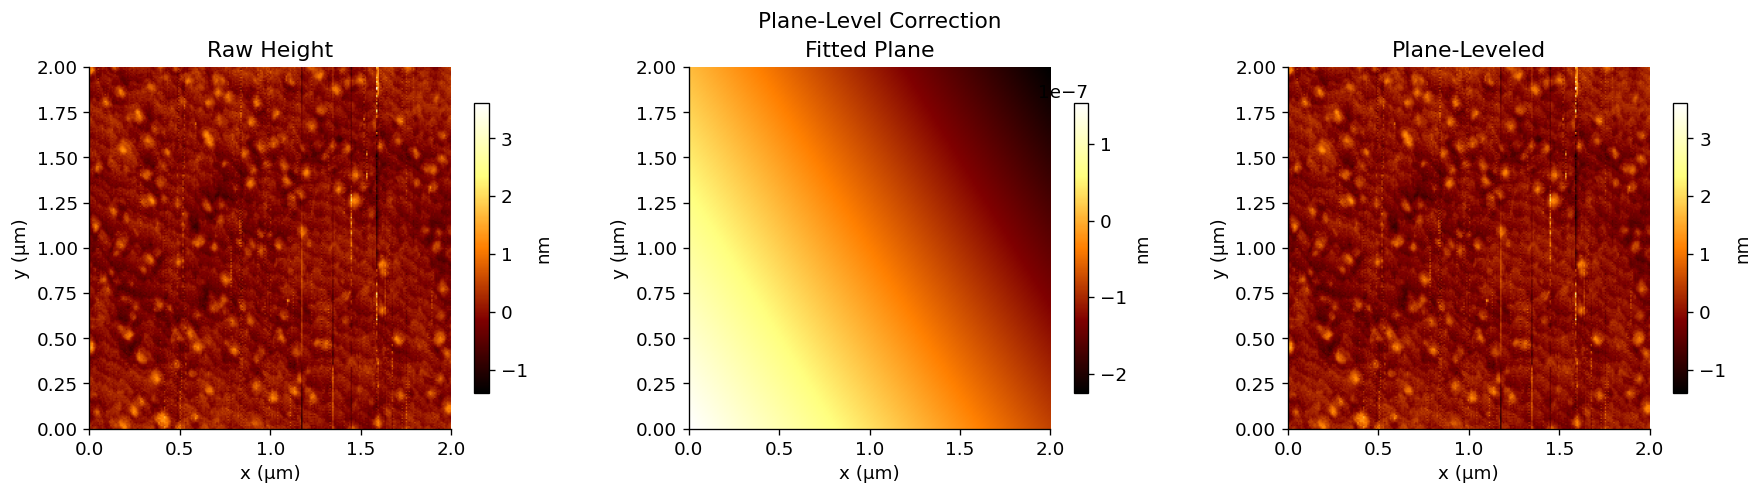

In [60]:
def plane_level(height):
    """Fit and subtract a least-squares plane from a 2D height array."""
    rows, cols = height.shape
    X, Y = np.meshgrid(np.arange(cols), np.arange(rows))
    
    # Build design matrix [1, x, y] for plane fit
    A = np.column_stack([np.ones(rows*cols), X.ravel(), Y.ravel()])
    b = height.ravel()
    
    coeffs, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    plane = (coeffs[0] + coeffs[1]*X + coeffs[2]*Y)
    
    leveled = height - plane
    return leveled, plane, coeffs

height_leveled, plane_fit, plane_coeffs = plane_level(height_raw)

# Tilt angle in mrad
tilt_x = np.degrees(np.arctan(plane_coeffs[1] / (1/px_size_nm))) * 1000  # mrad
tilt_y = np.degrees(np.arctan(plane_coeffs[2] / (1/px_size_nm))) * 1000

print(f"Plane removed — tilt: x={plane_coeffs[1]:.4f} nm/px, y={plane_coeffs[2]:.4f} nm/px")
print(f"Leveled height range: {height_leveled.min():.3f} – {height_leveled.max():.3f} nm")

# ── Visualize ───────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
extent = [0, SCAN_SIZE_UM, 0, SCAN_SIZE_UM]

for ax, img, title in zip(axes,
    [height_raw, plane_fit, height_leveled],
    ['Raw Height', 'Fitted Plane', 'Plane-Leveled']):
    im = ax.imshow(img, cmap='afmhot', origin='lower', extent=extent)
    ax.set_title(title)
    ax.set_xlabel('x (μm)'); ax.set_ylabel('y (μm)')
    cbar = fig.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('nm')

plt.suptitle('Plane-Level Correction', fontsize=13)
plt.tight_layout()
plt.show()

## 4. Surface Background Characterization

Before segmenting particles, we need to understand the **substrate surface statistics**. We estimate the background by looking at the lower portion of the height distribution (pixels below the median), which captures the flat surface rather than particles.

This gives us:
- The surface roughness baseline (Sq, Sa)
- A statistically motivated threshold height for particle detection
- Confirmation that the height distribution is bimodal (substrate + particles) or unimodal (no particles / pure roughness)

Background surface stats:
  Mean height:  -0.171 nm
  Std dev (Sq): 0.118 nm
  Sa:           0.094 nm


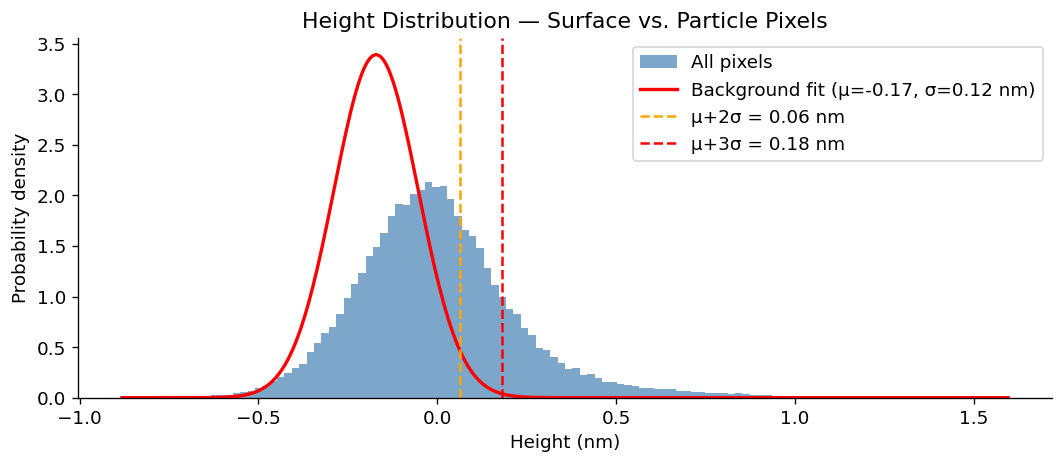


Threshold candidates:
  μ + 2σ = 0.064 nm
  μ + 3σ = 0.182 nm


In [61]:
# ── Apply mild Gaussian smoothing for segmentation ──────────────
# (preserves particle features while reducing single-pixel noise)
height_smooth = gaussian_filter(height_leveled.astype(float), sigma=0.8)

# ── Background estimation: use pixels below median ──────────────
median_h = np.median(height_smooth)
background_px = height_smooth[height_smooth <= median_h]

bg_mean = background_px.mean()
bg_std  = background_px.std()

print(f"Background surface stats:")
print(f"  Mean height:  {bg_mean:.3f} nm")
print(f"  Std dev (Sq): {bg_std:.3f} nm")
print(f"  Sa:           {np.mean(np.abs(background_px - bg_mean)):.3f} nm")

# ── Height histogram with background fit ────────────────────────
fig, ax = plt.subplots(figsize=(9, 4))

counts, bin_edges, _ = ax.hist(height_smooth.ravel(), bins=120,
                                color='steelblue', alpha=0.7, density=True,
                                label='All pixels')

# Overlay Gaussian fit to background
x_fit = np.linspace(height_smooth.min(), height_smooth.max(), 400)
gauss_bg = norm.pdf(x_fit, bg_mean, bg_std)
ax.plot(x_fit, gauss_bg, 'r-', lw=2, label=f'Background fit (μ={bg_mean:.2f}, σ={bg_std:.2f} nm)')

# Mark threshold candidates
thresh_2sig = bg_mean + 2 * bg_std
thresh_3sig = bg_mean + 3 * bg_std
ax.axvline(thresh_2sig, color='orange', ls='--', lw=1.5, label=f'μ+2σ = {thresh_2sig:.2f} nm')
ax.axvline(thresh_3sig, color='red',    ls='--', lw=1.5, label=f'μ+3σ = {thresh_3sig:.2f} nm')

ax.set_xlabel('Height (nm)'); ax.set_ylabel('Probability density')
ax.set_title('Height Distribution — Surface vs. Particle Pixels')
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nThreshold candidates:")
print(f"  μ + 2σ = {thresh_2sig:.3f} nm")
print(f"  μ + 3σ = {thresh_3sig:.3f} nm")

## 5. Particle Segmentation — Threshold Comparison

We compare three thresholding strategies:

- **μ + 2σ** — liberal threshold, catches faint particles but may include roughness noise
- **μ + 3σ** — conservative threshold, higher confidence but may miss smaller particles  
- **Otsu's method** — automatic global threshold that minimizes intra-class variance; data-driven and reproducible

The binary mask is then cleaned with a morphological opening (removes isolated noise pixels) and small-object filtering.

Otsu threshold: 0.043 nm


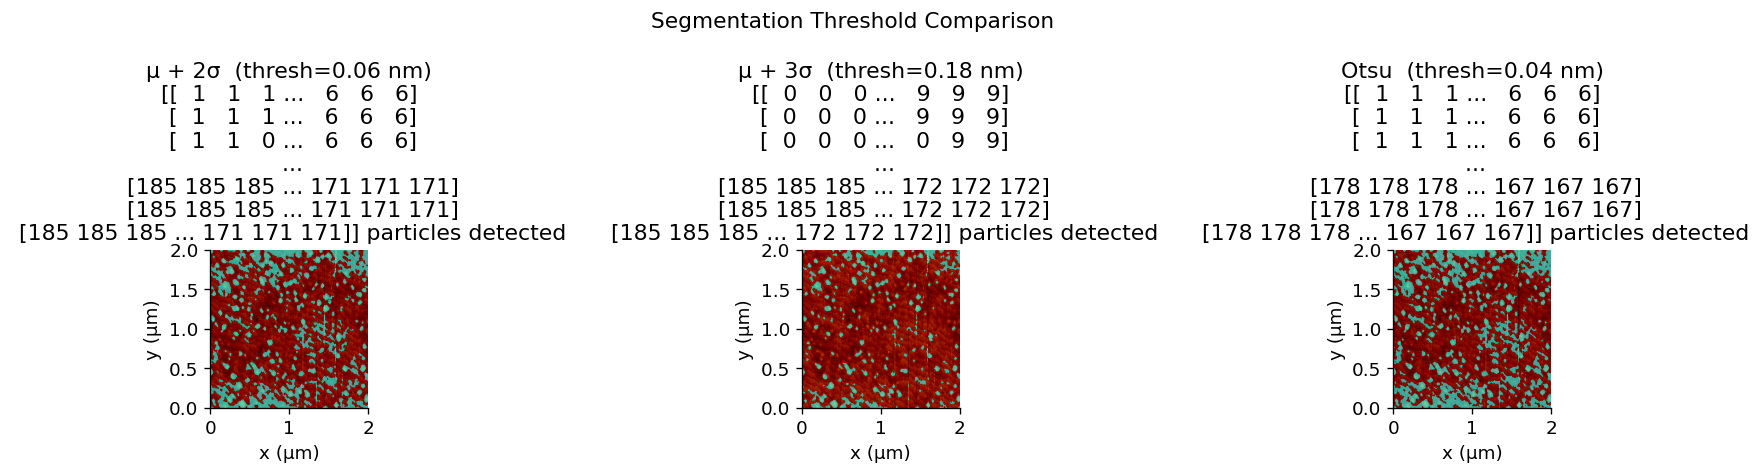

In [62]:
otsu_thresh = threshold_otsu(height_smooth)
print(f"Otsu threshold: {otsu_thresh:.3f} nm")

methods = {
    'μ + 2σ':  thresh_2sig,
    'μ + 3σ':  thresh_3sig,
    'Otsu':    otsu_thresh,
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, thresh) in zip(axes, methods.items()):
    binary = height_smooth > thresh
    # Morphological opening: removes single-pixel noise blobs
    binary_clean = binary_opening(binary, footprint=disk(1))
    binary_clean = remove_small_objects(binary_clean, min_size=MIN_PARTICLE_PX)
    
    n_labels, _ = nd_label(binary_clean)
    ax.imshow(height_leveled, cmap='afmhot', origin='lower', extent=extent)
    ax.imshow(np.ma.masked_where(~binary_clean, binary_clean),
              cmap='cool', alpha=0.6, origin='lower', extent=extent)
    ax.set_title(f"{name}  (thresh={thresh:.2f} nm)\n{n_labels} particles detected")
    ax.set_xlabel('x (μm)'); ax.set_ylabel('y (μm)')

plt.suptitle('Segmentation Threshold Comparison', fontsize=13)
plt.tight_layout()
plt.show()

## 6. Final Segmentation & Particle Labeling

We select the best threshold from the comparison above and produce the final labeled image. Each particle is assigned a unique integer label for individual analysis.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7682160089989504..1.9844436499317035].


Selected method: μ + 3σ  (threshold = 0.182 nm)
Particles detected (after edge removal): 164


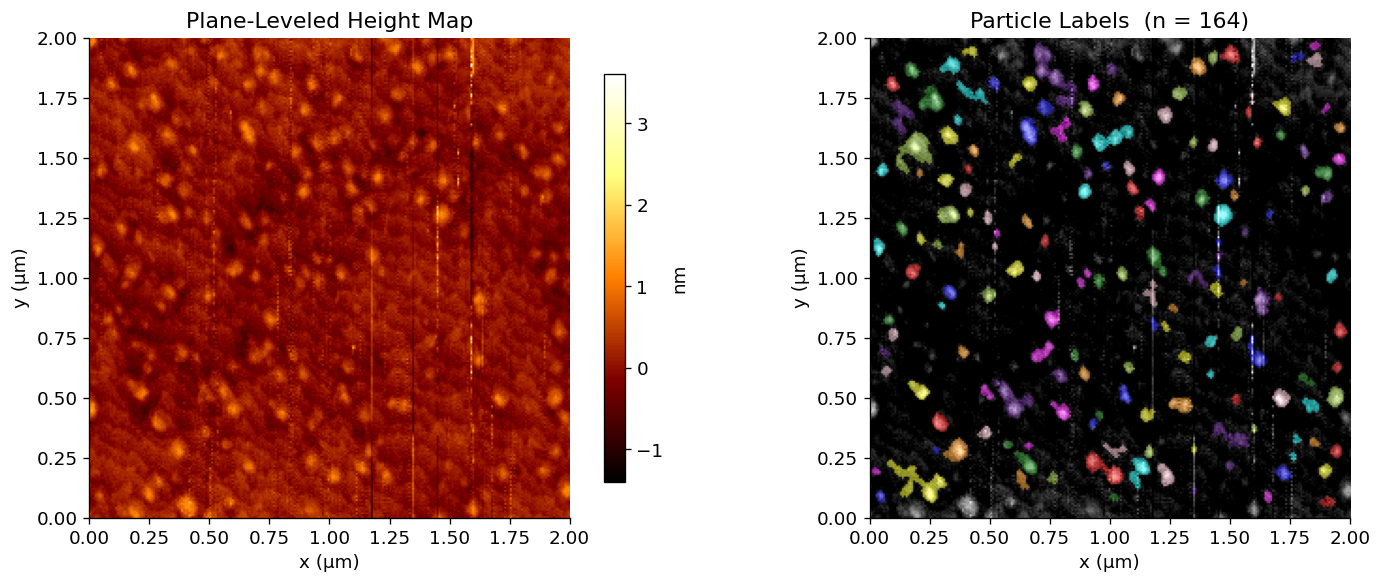

In [63]:
# ── Select threshold (change 'Otsu' to 'μ + 2σ' or 'μ + 3σ' if preferred) ──
SELECTED_METHOD = 'μ + 3σ'
selected_thresh = methods[SELECTED_METHOD]

binary_final = height_smooth > selected_thresh
binary_final = binary_opening(binary_final, footprint=disk(1))
binary_final = remove_small_objects(binary_final, min_size=MIN_PARTICLE_PX)
binary_final = clear_border(binary_final)   # remove edge-touching particles

labeled_array, n_particles = nd_label(binary_final)
print(f"Selected method: {SELECTED_METHOD}  (threshold = {selected_thresh:.3f} nm)")
print(f"Particles detected (after edge removal): {n_particles}")

# ── Labeled overlay ─────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].imshow(height_leveled, cmap='afmhot', origin='lower', extent=extent)
axes[0].set_title('Plane-Leveled Height Map')
axes[0].set_xlabel('x (μm)'); axes[0].set_ylabel('y (μm)')
cbar = fig.colorbar(cm.ScalarMappable(norm=Normalize(height_leveled.min(), height_leveled.max()),
                    cmap='afmhot'), ax=axes[0], shrink=0.85)
cbar.set_label('nm')

# Labeled map
from skimage.color import label2rgb
labeled_rgb = label2rgb(labeled_array, image=height_leveled,
                         bg_label=0, alpha=0.45, kind='overlay')
axes[1].imshow(labeled_rgb, origin='lower', extent=extent)
axes[1].set_title(f'Particle Labels  (n = {n_particles})')
axes[1].set_xlabel('x (μm)'); axes[1].set_ylabel('y (μm)')

plt.tight_layout()
plt.show()

## 7. Per-Particle Feature Extraction

Using `skimage.measure.regionprops` we extract a rich set of geometric and height-based metrics for every labeled particle:

| Feature | Description |
|---|---|
| **Equivalent diameter** | Diameter of a circle with the same area |
| **Max height** | Peak height above leveled surface |
| **Mean height** | Average height within particle footprint |
| **Area (nm²)** | Projected area of the particle |
| **Aspect ratio** | Major/minor axis ratio (1.0 = circular) |
| **Centroid x/y** | Position in μm |

These features can later serve as inputs to a classifier (Priority 3 ML extension).

In [64]:
props = regionprops(labeled_array, intensity_image=height_leveled)

records = []
for p in props:
    area_px   = p.area
    area_nm2  = area_px * (px_size_nm ** 2)
    area_um2  = area_nm2 * 1e-6

    eq_diam_nm = np.sqrt(4 * area_nm2 / np.pi)

    # Height stats within particle mask
    particle_heights = height_leveled[labeled_array == p.label]
    max_h  = particle_heights.max()
    mean_h = particle_heights.mean()

    # Shape
    major = p.major_axis_length * px_size_nm
    minor = p.minor_axis_length * px_size_nm
    aspect = major / minor if minor > 0 else np.nan

    # Position in μm
    cy, cx = p.centroid
    cx_um = cx * px_size_um
    cy_um = cy * px_size_um

    records.append({
        'Particle ID':       p.label,
        'Centroid x (μm)':   round(cx_um, 4),
        'Centroid y (μm)':   round(cy_um, 4),
        'Area (nm²)':        round(area_nm2, 1),
        'Eq. Diameter (nm)': round(eq_diam_nm, 2),
        'Max Height (nm)':   round(max_h, 3),
        'Mean Height (nm)':  round(mean_h, 3),
        'Aspect Ratio':      round(aspect, 3),
        'Major Axis (nm)':   round(major, 2),
        'Minor Axis (nm)':   round(minor, 2),
    })

particle_df = pd.DataFrame(records)
print(f"Extracted features for {len(particle_df)} particles\n")
particle_df.head(10)

Extracted features for 164 particles



,Particle ID,Centroid x (μm),Centroid y (μm),Area (nm²),Eq. Diameter (nm),Max Height (nm),Mean Height (nm),Aspect Ratio,Major Axis (nm),Minor Axis (nm)
0,1,1.8992,0.0625,1953.1,49.87,0.556,0.257,1.508,63.24,41.95
1,2,0.0407,0.0846,1464.8,43.19,0.778,0.425,1.434,51.61,35.99
2,3,0.1997,0.1443,15441.9,140.22,1.214,0.379,2.130,273.29,128.32
3,4,1.6516,0.0842,1342.8,41.35,0.603,0.369,1.659,52.67,31.74
4,5,1.0117,0.0820,976.6,35.26,0.495,0.256,1.563,43.65,27.93
5,6,1.3438,0.1094,671.4,29.24,0.941,0.376,1.528,35.25,23.08
6,7,0.6279,0.1543,2624.5,57.81,0.525,0.293,2.336,90.23,38.63
7,8,1.1149,0.1910,6469.7,90.76,1.252,0.411,1.794,134.45,74.96
8,9,1.2268,0.1748,4333.5,74.28,1.012,0.458,1.813,102.84,56.71
9,10,0.7578,0.1614,1586.9,44.95,0.567,0.276,1.176,49.83,42.36


## 8. Population Statistics & Size Distribution

With per-particle data in a DataFrame, we can apply standard statistical analysis to characterize the particle population as a whole.

In [65]:
print("=== Particle Population Summary ===")
print(particle_df[['Eq. Diameter (nm)', 'Max Height (nm)',
                    'Area (nm²)', 'Aspect Ratio']].describe().round(3))

# ── Particle density ────────────────────────────────────────────
scan_area_um2 = SCAN_SIZE_UM ** 2
density = len(particle_df) / scan_area_um2
print(f"\nParticle density: {density:.2f} particles/μm²")
print(f"Scan area:        {scan_area_um2:.3f} μm²")

=== Particle Population Summary ===
       Eq. Diameter (nm)  Max Height (nm)  Area (nm²)  Aspect Ratio
count            164.000          164.000     164.000       164.000
mean              54.174            0.850    2672.152         1.542
std               21.687            0.339    2515.134         0.451
min               27.880            0.314     610.400         1.039
25%               38.430            0.593    1159.700         1.230
50%               49.870            0.812    1953.100         1.424
75%               63.570            1.054    3173.800         1.659
max              148.560            2.564   17334.000         3.462

Particle density: 41.00 particles/μm²
Scan area:        4.000 μm²


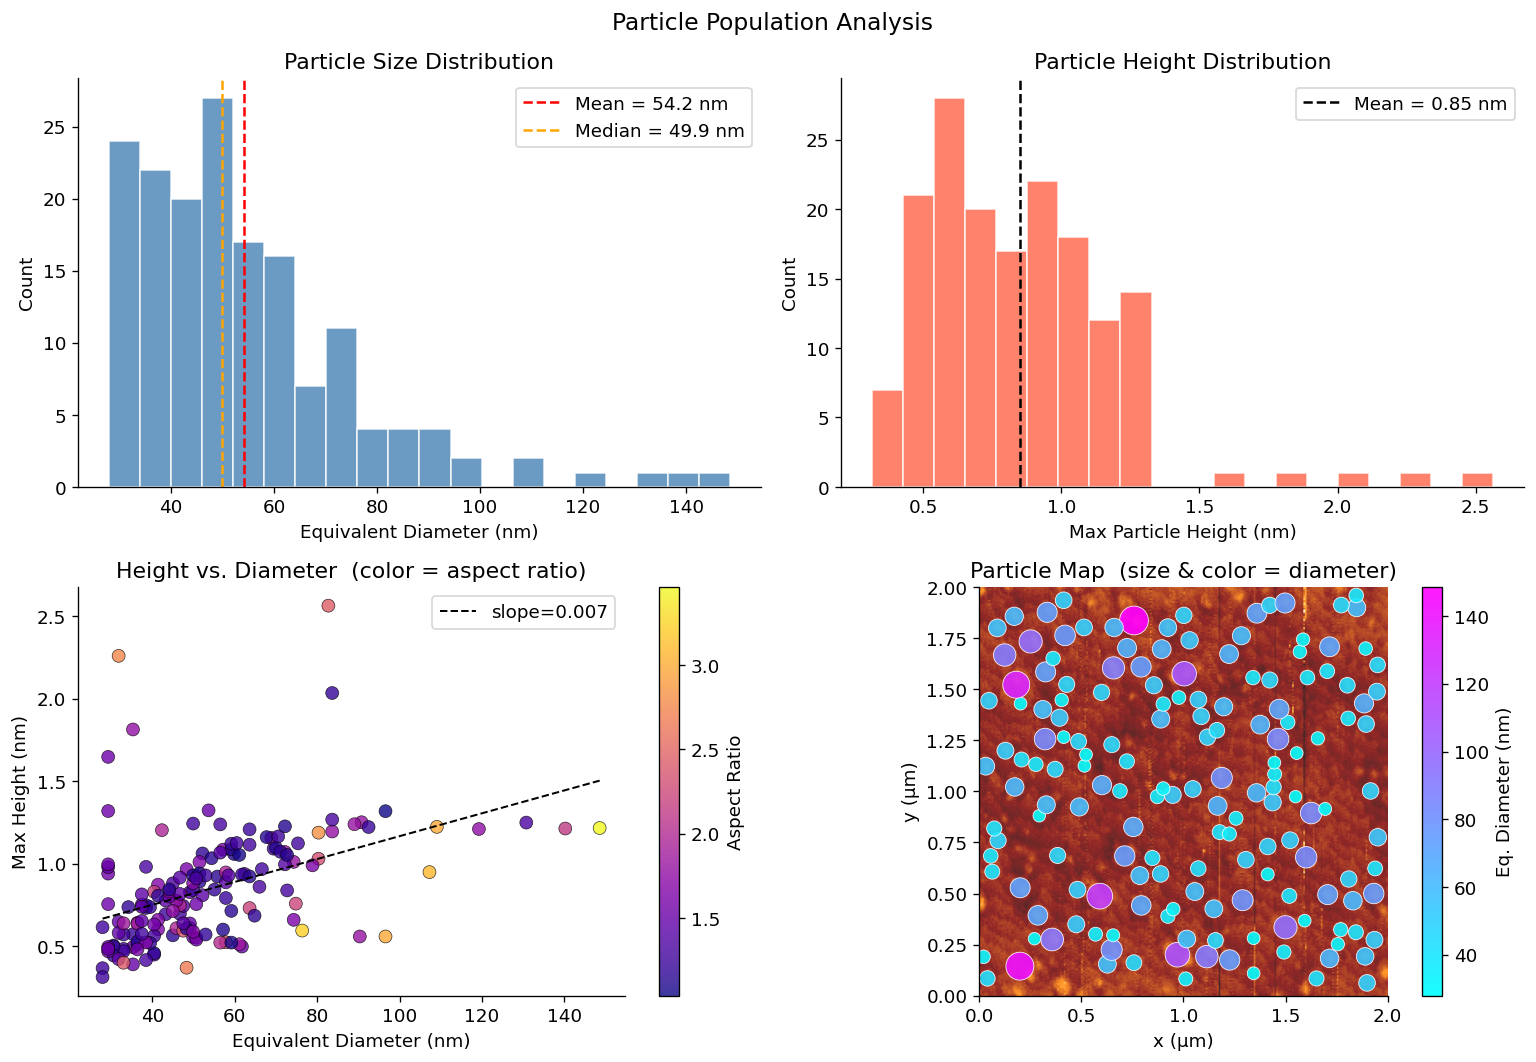

In [66]:
fig, axes = plt.subplots(2, 2, figsize=(13, 9))

# ── Diameter distribution ───────────────────────────────────────
ax = axes[0, 0]
diams = particle_df['Eq. Diameter (nm)']
ax.hist(diams, bins=20, color='steelblue', alpha=0.8, edgecolor='white')
ax.axvline(diams.mean(), color='red',    ls='--', lw=1.5, label=f'Mean = {diams.mean():.1f} nm')
ax.axvline(diams.median(), color='orange', ls='--', lw=1.5, label=f'Median = {diams.median():.1f} nm')
ax.set_xlabel('Equivalent Diameter (nm)'); ax.set_ylabel('Count')
ax.set_title('Particle Size Distribution'); ax.legend()

# ── Height distribution ─────────────────────────────────────────
ax = axes[0, 1]
heights = particle_df['Max Height (nm)']
ax.hist(heights, bins=20, color='tomato', alpha=0.8, edgecolor='white')
ax.axvline(heights.mean(), color='black', ls='--', lw=1.5, label=f'Mean = {heights.mean():.2f} nm')
ax.set_xlabel('Max Particle Height (nm)'); ax.set_ylabel('Count')
ax.set_title('Particle Height Distribution'); ax.legend()

# ── Height vs Diameter scatter ──────────────────────────────────
ax = axes[1, 0]
sc = ax.scatter(particle_df['Eq. Diameter (nm)'], particle_df['Max Height (nm)'],
                c=particle_df['Aspect Ratio'], cmap='plasma',
                alpha=0.8, edgecolors='k', linewidths=0.4, s=60)
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Aspect Ratio')
ax.set_xlabel('Equivalent Diameter (nm)'); ax.set_ylabel('Max Height (nm)')
ax.set_title('Height vs. Diameter  (color = aspect ratio)')

# Fit linear trend
m, b = np.polyfit(particle_df['Eq. Diameter (nm)'], particle_df['Max Height (nm)'], 1)
x_line = np.linspace(diams.min(), diams.max(), 100)
ax.plot(x_line, m*x_line + b, 'k--', lw=1.2, label=f'slope={m:.3f}')
ax.legend()

# ── Spatial map of particles ────────────────────────────────────
ax = axes[1, 1]
ax.imshow(height_leveled, cmap='afmhot', origin='lower', extent=extent, alpha=0.85)
sc2 = ax.scatter(particle_df['Centroid x (μm)'], particle_df['Centroid y (μm)'],
                 c=particle_df['Eq. Diameter (nm)'], cmap='cool',
                 s=particle_df['Eq. Diameter (nm)'] * 2,
                 edgecolors='white', linewidths=0.5, alpha=0.9)
cbar2 = fig.colorbar(sc2, ax=ax)
cbar2.set_label('Eq. Diameter (nm)')
ax.set_xlabel('x (μm)'); ax.set_ylabel('y (μm)')
ax.set_title('Particle Map  (size & color = diameter)')

plt.suptitle('Particle Population Analysis', fontsize=14)
plt.tight_layout()
plt.show()

## 9. Publication-Style Annotated Particle Map

A clean annotated overlay suitable for a paper or report — each detected particle is outlined and labeled with its ID.

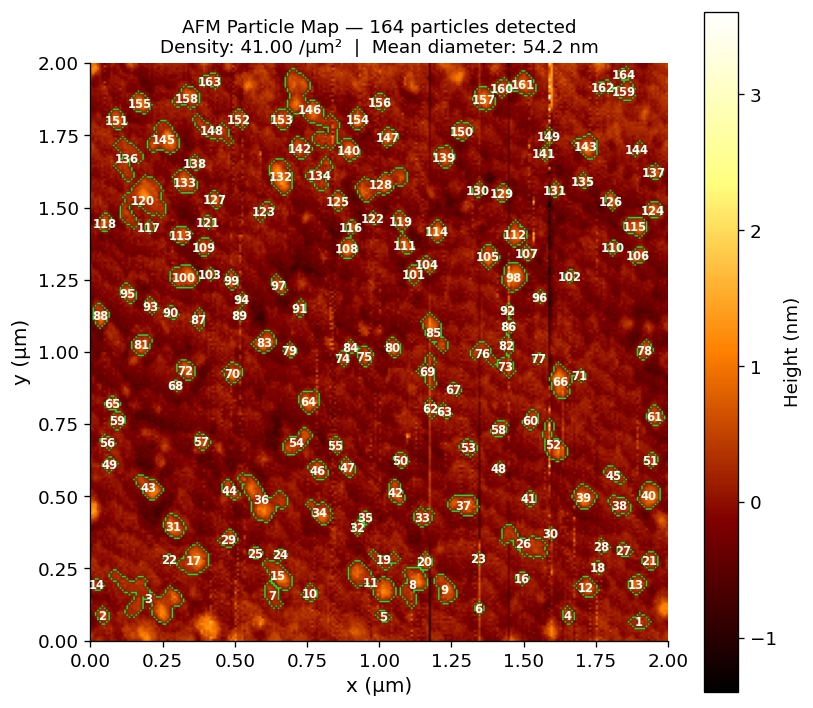

In [67]:
from skimage.segmentation import find_boundaries

fig, ax = plt.subplots(figsize=(7, 7))

ax.imshow(height_leveled, cmap='afmhot', origin='lower', extent=extent)

# Draw particle boundaries
boundary_mask = find_boundaries(labeled_array, mode='outer')
boundary_rgba = np.zeros((*boundary_mask.shape, 4))
boundary_rgba[boundary_mask] = [0.2, 0.9, 0.2, 0.9]   # bright green
ax.imshow(boundary_rgba, origin='lower', extent=extent)

# Label each particle centroid
for _, row in particle_df.iterrows():
    ax.text(row['Centroid x (μm)'], row['Centroid y (μm)'],
            str(int(row['Particle ID'])),
            color='white', fontsize=7, ha='center', va='center',
            fontweight='bold')

ax.set_xlabel('x (μm)', fontsize=12)
ax.set_ylabel('y (μm)', fontsize=12)
ax.set_title(f'AFM Particle Map — {n_particles} particles detected\n'
             f'Density: {density:.2f} /μm²  |  '
             f'Mean diameter: {diams.mean():.1f} nm', fontsize=11)

# Colorbar
sm = cm.ScalarMappable(cmap='afmhot',
     norm=Normalize(height_leveled.min(), height_leveled.max()))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.85)
cbar.set_label('Height (nm)', fontsize=11)

plt.tight_layout()
plt.show()

## 10. Analysis Summary Scorecard

In [68]:
print("\n" + "="*60)
print("     AFM PARTICLE ANALYSIS SCORECARD — GV0130001")
print("="*60)
summary = {
    "File":                      FILE_PATH,
    "Image size":                f"{n_rows}×{n_cols} px  ({SCAN_SIZE_UM:.3f} × {SCAN_SIZE_UM:.3f} μm)",
    "Pixel size":                f"{px_size_nm:.3f} nm/px",
    "Segmentation method":       f"{SELECTED_METHOD} (threshold = {selected_thresh:.3f} nm)",
    "Particles detected":        str(n_particles),
    "Particle density":          f"{density:.3f} /μm²",
    "Mean eq. diameter":         f"{diams.mean():.2f} ± {diams.std():.2f} nm",
    "Median eq. diameter":       f"{diams.median():.2f} nm",
    "Mean max height":           f"{heights.mean():.3f} ± {heights.std():.3f} nm",
    "Height–diameter slope":     f"{m:.4f} nm/nm  (linear fit)",
    "Background Sq (roughness)": f"{bg_std:.3f} nm",
}
for k, v in summary.items():
    print(f"  {k:<32} {v}")
print("="*60)

# Export particle data
particle_df.to_csv("particle_features.csv", index=False)
print("\nParticle feature table saved to: particle_features.csv")


     AFM PARTICLE ANALYSIS SCORECARD — GV0130001
  File                             GV0130001.ibw
  Image size                       256×256 px  (2.000 × 2.000 μm)
  Pixel size                       7.812 nm/px
  Segmentation method              μ + 3σ (threshold = 0.182 nm)
  Particles detected               164
  Particle density                 41.000 /μm²
  Mean eq. diameter                54.17 ± 21.69 nm
  Median eq. diameter              49.87 nm
  Mean max height                  0.850 ± 0.339 nm
  Height–diameter slope            0.0069 nm/nm  (linear fit)
  Background Sq (roughness)        0.118 nm

Particle feature table saved to: particle_features.csv
